# Distance to Ust Ishim individual


Figure out if swept and non-swept haplotypes have a different relation to Ust Ishim individual


In [2]:
import re, os, sys, pickle, pickle, math
from pathlib import Path
import numpy
import pandas
import scipy
from pandas import DataFrame, Series

numpy.random.seed(7)

Plotting setup:

In [3]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D 
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}

Ignore deprecation warnings from mainly seaborn:

In [4]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

Analysis dirs:

In [5]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

Import variables global to the entire analysis:

In [6]:
import analysis_globals

Local code in the scripts dir on the cluster:

In [6]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

## Convenience functions

In [7]:
def silent_nanmean(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return numpy.nanmean(x)
    
def ident_scalar(s):
    x = s.unique()
    assert(len(x)) == 1
    return x[0]

def bootstrap_se(sr, n=10000):
    means = list()
    for i in range(n):
        means.append(numpy.mean(sr.sample(frac=1, replace=True)))
    return numpy.std(means)

In [8]:
import time
class Timer:    
    def __enter__(self):
        self.start = time.clock()
        return self

    def __exit__(self, *args):
        self.end = time.clock()
        self.interval = self.end - self.start
        print("{:.0f} min {:.1f} sec".format(self.interval//60, self.interval % 60))

## Load meta data

In [9]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

## Load data for each individual

In [10]:
#all_male_indiv_dist = pandas.read_hdf(results_dir / 'all_male_indiv_dist.hdf')
sweep_data = (pandas.read_hdf(results_dir / 'sweep_data.hdf')
              .loc[lambda df: df.not_missing == True] # only include windows where enough individuals are called
             )
sweep_data.head()

,indiv_1,start,end,pop_1,region_label_1,region_id_1,region_1,mean_dist,mean_dist_af,mean_dist_to_africans,...,swept_af,not_missing,never_swept,never_swept_af,never_win_swept,never_win_swept_af,conserv_swept_group,conserv_swept_group_af,partial_sweep_win,partial_sweep_win_af
27,B_Australian-4,2700000,2800000,Australian,Oceania,4,Oceania,0.001051,0.001051,0.001735,...,False,True,True,True,True,True,no,no,False,False
28,B_Australian-4,2800000,2900000,Australian,Oceania,4,Oceania,0.000633,0.000623,0.001109,...,False,True,True,True,True,True,no,no,False,False
29,B_Australian-4,2900000,3000000,Australian,Oceania,4,Oceania,0.000377,0.000318,0.000844,...,False,True,True,True,False,False,no,no,False,False
30,B_Australian-4,3000000,3100000,Australian,Oceania,4,Oceania,0.001087,0.001087,0.001078,...,False,True,True,True,True,True,no,no,False,False
31,B_Australian-4,3100000,3200000,Australian,Oceania,4,Oceania,0.001212,0.001205,0.001544,...,False,True,True,True,True,True,no,no,False,False


## Build data frame with distances to Ust Ishim

Ust Ishim is indiv_2 in each pair.

In [13]:
def read_dist_table(file_name):

    col_names = ['chrom', 'start', 'end', 'pop_label',
                 'indiv_1', 'pseud_1', 'indiv_2', 'pseud_2',
                 'dist', 'mismatch', 'match',
                 'dist_af', 'mismatch_af', 'match_af',
                 'uncalled']
    
    with open(str(file_name), 'rb') as f:
        table = pickle.load(f)
    df = DataFrame(table, columns=col_names)
    df['indiv1'] = [Path(x).name for x in df.indiv_1]
    df['indiv2'] = [Path(x).name for x in df.indiv_2]
    return df

def indiv_filter(df):
    indiv1_in_meta = [x in individuals_and_ust_ishim for x in df.indiv_1]
    indiv2_in_meta = [x in individuals_and_ust_ishim for x in df.indiv_2]
    return([x and y for x, y in zip(indiv1_in_meta, indiv2_in_meta)])

def swap_indiv_to_put_ust_ishim_last(s1, s2):
    l = list()
    for indiv1, indiv2 in zip(s1, s2):
        if 'Ust_Ishim' in indiv1:
            l.append((indiv2, indiv1))
        else:
            l.append((indiv1, indiv2))
    return l

individuals_and_ust_ishim = set(list(individuals.keys()) + ['Ust_Ishim'])

In [14]:
dist_dir = steps_dir / 'male_x_haploid_dist_admix_masked'

ust_ishim_dist_data = (pandas.concat(map(read_dist_table, dist_dir.glob('*Ust_Ishim*'))) # read and concat pi tables
                    .loc[indiv_filter]
                    .reset_index(drop=True)
                    )

ust_ishim_dist_data['indiv_1'], ust_ishim_dist_data['indiv_2'] = \
    zip(*swap_indiv_to_put_ust_ishim_last(ust_ishim_dist_data['indiv_1'], ust_ishim_dist_data['indiv_2']))

ust_ishim_dist_data.head()

,chrom,start,end,pop_label,indiv_1,pseud_1,indiv_2,pseud_2,dist,mismatch,match,dist_af,mismatch_af,match_af,uncalled,indiv1,indiv2
0,X,0,100000,NA,S_Czech-2,A,Ust_Ishim,A,0.006421,4,619,0.006421,4,619,99377,S_Czech-2,Ust_Ishim
1,X,100000,200000,NA,S_Czech-2,A,Ust_Ishim,A,0.000986,5,5066,0.000986,5,5066,94929,S_Czech-2,Ust_Ishim
2,X,200000,300000,NA,S_Czech-2,A,Ust_Ishim,A,0.004992,23,4584,0.004992,23,4584,95393,S_Czech-2,Ust_Ishim
3,X,300000,400000,NA,S_Czech-2,A,Ust_Ishim,A,0.001456,11,7543,0.001456,11,7543,92446,S_Czech-2,Ust_Ishim
4,X,400000,500000,NA,S_Czech-2,A,Ust_Ishim,A,0.001162,4,3438,0.001162,4,3438,96558,S_Czech-2,Ust_Ishim


Distribution of uncalled bases. We allow up to 70000 uncalled.

In [15]:
analysis_globals.ust_ishim_max_uncalled_bases

70000

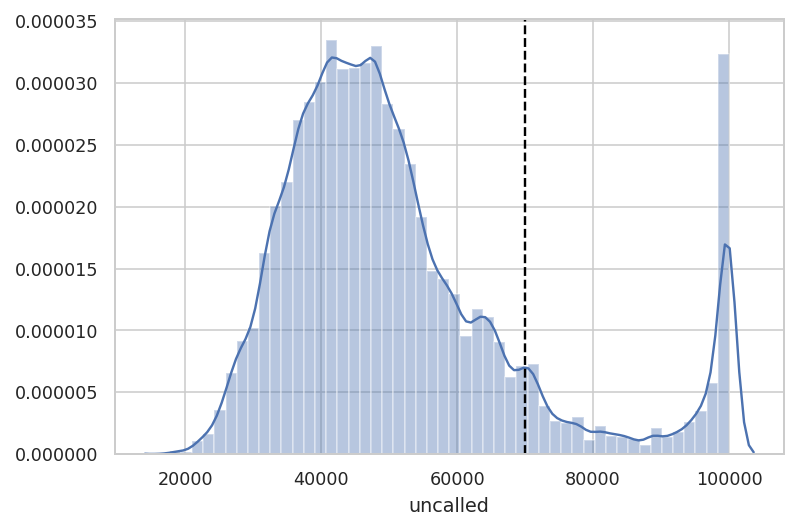

In [16]:

g = sns.distplot(ust_ishim_dist_data.uncalled)
g = g.axvline(analysis_globals.ust_ishim_max_uncalled_bases, linestyle='dashed', color='black')

In [17]:
# tmp_indivs = ['B_Crete-2', 'B_French-3', 'B_Sardinian-3', 'S_Abkhasian-2', 'S_Adygei-1', 'S_Aleut-1', 'S_Altaian-1', 'S_Armenian-1', 'S_Armenian-2', 'S_Atayal-1', 'S_Balochi-2', 'S_Bengali-1', 'S_Bergamo-1', 'S_Brahmin-2', 'S_Bulgarian-1', 'S_Bulgarian-2', 'S_Burmese-1', 'S_Chechen-1', 'S_Chukchi-1', 'S_Druze-2', 'S_Estonian-1', 'S_Estonian-2', 'S_Finnish-3', 'S_French-1', 'S_Georgian-1', 'S_Georgian-2', 'S_Greek-1', 'S_Greek-2', 'S_Hazara-2', 'S_Hungarian-2', 'S_Igorot-2', 'S_Iranian-1', 'S_Iranian-2', 'S_Irula-1', 'S_Japanese-1', 'S_Japanese-3', 'S_Jordanian-2', 'S_Jordanian-3', 'S_Kalash-1', 'S_Kapu-1', 'S_Kapu-2', 'S_Karitiana-1', 'S_Lahu-2', 'S_Lezgin-2', 'S_Madiga-1', 'S_Mala-2', 'S_Mala-3', 'S_Maori-1', 'S_Miao-1', 'S_North_Ossetian-1', 'S_Orcadian-1', 'S_Pathan-1', 'S_Polish-1', 'S_Punjabi-2', 'S_Relli-2', 'S_Samaritan-1', 'S_She-2', 'S_Sindhi-1', 'S_Tajik-1', 'S_Tajik-2', 'S_Tlingit-1', 'S_Uygur-2', 'S_Xibo-2', 'S_Yadava-2']

# sns.distplot(ust_ishim_dist_data
#  .loc[(ust_ishim_dist_data.start>= 74000000) &\
#       (ust_ishim_dist_data.end<= 74400000) &\
#       (ust_ishim_dist_data.indiv_1.isin(tmp_indivs))]
#  .uncalled
# )

In [18]:
ust_ishim_dist_data = ust_ishim_dist_data.loc[lambda df: df.uncalled <= analysis_globals.ust_ishim_max_uncalled_bases]
ust_ishim_dist_data.head()

,chrom,start,end,pop_label,indiv_1,pseud_1,indiv_2,pseud_2,dist,mismatch,match,dist_af,mismatch_af,match_af,uncalled,indiv1,indiv2
29,X,2900000,3000000,NA,S_Czech-2,A,Ust_Ishim,A,0.000210,7,33280,0.000210,7,33280,66713,S_Czech-2,Ust_Ishim
30,X,3000000,3100000,NA,S_Czech-2,A,Ust_Ishim,A,0.001165,41,35150,0.001165,41,35150,64809,S_Czech-2,Ust_Ishim
31,X,3100000,3200000,NA,S_Czech-2,A,Ust_Ishim,A,0.001555,56,35963,0.001555,56,35963,63981,S_Czech-2,Ust_Ishim
39,X,3900000,4000000,NA,S_Czech-2,A,Ust_Ishim,A,0.000084,5,59586,0.000084,5,59586,40409,S_Czech-2,Ust_Ishim
40,X,4000000,4100000,NA,S_Czech-2,A,Ust_Ishim,A,0.000034,2,58489,0.000034,2,58489,41509,S_Czech-2,Ust_Ishim


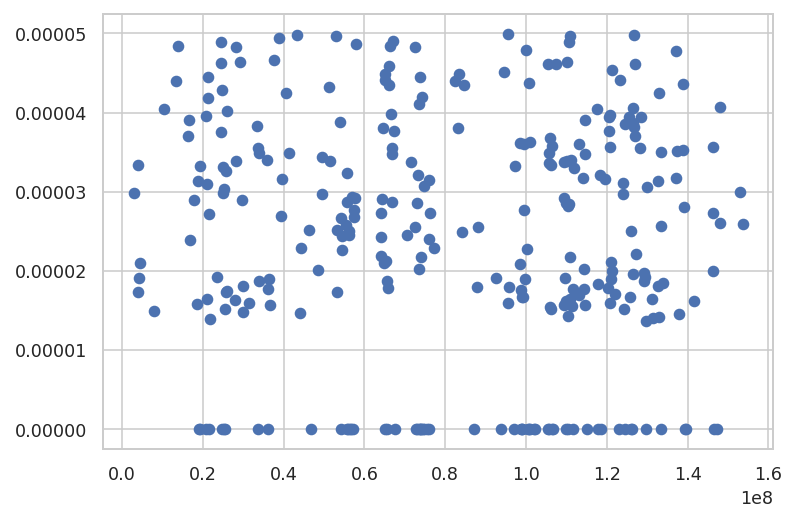

In [20]:
tmp = ust_ishim_dist_data.loc[(ust_ishim_dist_data.indiv_1 == 'S_Eskimo_Chaplin-1') & (ust_ishim_dist_data.dist < 5e-5), ['dist', 'start']] 
plt.plot(tmp.start, tmp.dist, 'o') ;


## Ust Ishim has a distribution of pairwise distances similar to other non-Africans

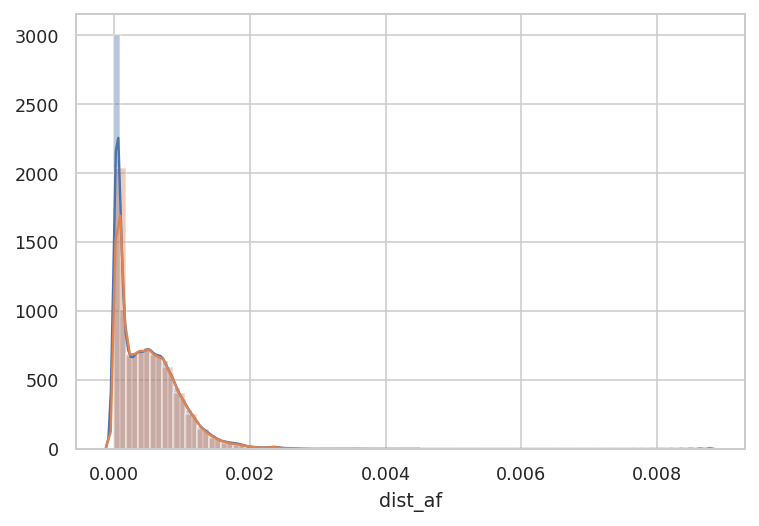

In [21]:
g = sns.distplot(ust_ishim_dist_data.dist)
g = sns.distplot(ust_ishim_dist_data.loc[lambda df: ~numpy.isnan(df.dist_af), 'dist_af'], ax=g)

In [22]:
(~numpy.isnan(ust_ishim_dist_data.dist_af)).sum()

217312

## Call sweeps in Ust ishim using cliques

Load the clique data and see how often Ust ishim is called and how it overlaps the extended regions.






## Call sweeps in Ust ishim

We scale our cut cutoff to take the Ust ishim sample age into account:

In [23]:
#yrs = analysis_globals.pwdist_cutoff / (4.1e-10 * 2)
yrs = 6.36e-5 / (analysis_globals.mut_per_year * 2)
BRANCH_SHORT = (yrs + (yrs-45000)) / (2*yrs)
BRANCH_SHORT
# BRANCH_SHORT = (60000 + (60000-45000)) / (2*60000)
BRANCH_SHORT * analysis_globals.pwdist_cutoff

# BRANCH_SHORT = (60000 + (60000-45000)) / (2*60000)
# BRANCH_SHORT * analysis_globals.pwdist_cutoff

3.4787735849056605e-05

### Important:

**NB:** the code below calls sweeps in the same was as in `scripts/sweep_calling.py`, but here we chante:

    analysis_globals.pwdist_cutoff

for

    BRANCH_SHORT * analysis_globals.pwdist_cutoff
    
to allow for branch shortening.

In [21]:
def call_rolling_windows(df):#, pwdist_cutoff, min_sweep_clade_size):
    """
    Takes a df with all pwdiffs in a 500kb rolling window between 
    one indiv and all other individuals. Returns all nan if one or more 100kb 
    windows are without any data. Computes mean pwdist across 
    the five 100kb windows between each pair. Calls sweep_clade as number 
    of other indivisuals with a pwdist smaller than cutoff. Calls as
    swept if this number is above cutoff. Computes mean_clade_dist as 
    mean pwdist in sweep clade.
    """
    
    def mean_indiv_dist(df, col):
        """
        Compute mean across 100kb windows in in 500kb window.
        """
        if len(df) != nr_wins:
            return numpy.nan
        return df[col].mean()
    
    if numpy.isnan(df.groupby('start')['dist'].mean()).any():
        # one or more 100kb has no dist data
        called, clade_size, mean_clade_dist = numpy.nan, numpy.nan, numpy.nan
    else:
        # mean distance between indiv_1 and each indiv_2 for the 500kb window
        pwdiffs = df.groupby(['indiv_2']).apply(mean_indiv_dist, 'dist')

        mean_clade_dist = pwdiffs.loc[pwdiffs <= BRANCH_SHORT * analysis_globals.pwdist_cutoff].mean() 
        
        # number of indiv_2 closer to indiv_1 than cutoff across the 500kb window
        clade_size = (pwdiffs <= BRANCH_SHORT * analysis_globals.pwdist_cutoff).sum() 
        
        # call if clade size is larger then cutoff
        called = clade_size >= analysis_globals.min_sweep_clade_size
    
    if numpy.isnan(df.groupby('start')['dist_af'].mean()).any():     
        called_af, clade_size_af, mean_clade_dist_af = numpy.nan, numpy.nan, numpy.nan
    else:
        pwdiffs_af = df.groupby(['indiv_2']).apply(mean_indiv_dist, 'dist_af')

        mean_clade_dist_af = pwdiffs.loc[pwdiffs_af <= BRANCH_SHORT * analysis_globals.pwdist_cutoff].mean() 

        clade_size_af = (pwdiffs_af <= BRANCH_SHORT * analysis_globals.pwdist_cutoff).sum()

        called_af = clade_size_af >= analysis_globals.min_sweep_clade_size

    return df.copy().assign(called=called, clade_size=clade_size, mean_clade_dist=mean_clade_dist,
                            called_af=called_af, clade_size_af=clade_size_af, mean_clade_dist_af=mean_clade_dist_af)


def call_swept(df):
    """
    Takes a df with all rolling window data for an indivisual for one 100kb window.
    Call each 100kb window as sweept if any overlapping rolling window is called as swept.
    Compute clade size and mean clade dist as from the rolling window with the largest clade size.
    """
    max_clade_size = df.clade_size.max()
    max_clade_size_af = df.clade_size_af.max()
    
    largest_clade_offsets = (df.groupby('off')
                             .filter(lambda df: (df.clade_size == max_clade_size).all() and df.called.all())
                            )
    largest_clade_offsets_af = (df.groupby('off')
                             .filter(lambda df: (df.clade_size_af == max_clade_size_af).all() and df.called_af.all())
                            )
    return DataFrame(dict(called=[df.called.any()], 
                          clade_size=[max_clade_size],
                          clade_mean_dist=[largest_clade_offsets['dist'].mean()],
                          called_af=[df.called_af.any()], 
                          clade_size_af=[max_clade_size_af],
                          clade_mean_dist_af=[largest_clade_offsets_af['dist_af'].mean()]))

In [22]:
nr_wins = 5
offsets = [x * 100000 for x in range(nr_wins)]
window_size = len(offsets) * 100000

from multiprocessing import Pool, cpu_count

nr_cpu = int(os.environ.get('SLURM_JOB_NUM_NODES'))

lst = list()
# loop over five offsets of 500kb windows
for off in offsets:
    with Timer():
        print(off)
        groups = (ust_ishim_dist_data
                  .assign(off=off, # keep offset
                          roll_win = lambda df: (off + df.start) // window_size) # label for rolling 500kb window
                 .groupby(['indiv_1', 'roll_win', 'off'])
                 )
        with Pool(nr_cpu) as p:
            df = pandas.concat(p.map(call_rolling_windows, [group for name, group in groups]))

#        df = pandas.concat([call_rolling_windows(group) for name, group in groups])
            
        lst.append(df)

0
1 min 43.0 sec
100000
1 min 42.0 sec
200000
1 min 42.5 sec
300000
1 min 44.1 sec
400000
1 min 43.4 sec


In [23]:
with Timer():
    ust_ishim_sweep_calls = (pandas.concat(lst)
                   .groupby(['indiv_1', 'start'])
                   .apply(call_swept)
                   .reset_index(level=['indiv_1', 'start'])
                  )

29 min 0.8 sec


In [24]:
def run_id(sr):
    return (sr != sr.shift()).cumsum()

ust_ishim_sweep_calls['run_id'] = (ust_ishim_sweep_calls
                        .groupby('indiv_1')['called']
                        .apply(run_id)
                       )
ust_ishim_sweep_calls['run_length'] = (ust_ishim_sweep_calls
                            .groupby(['indiv_1', 'run_id'])['run_id']
                            .transform(numpy.size)
                           )
ust_ishim_sweep_calls['swept'] = numpy.bitwise_and(ust_ishim_sweep_calls['called'], 
                                        ust_ishim_sweep_calls['run_length'] >= analysis_globals.min_run_length)

In [25]:
ust_ishim_sweep_calls.called.sum()

0

Conclusion is that it is not possible to call sweeps as we do on non-Africans, likely due to either missing data or misscalled bases bringing dist above cutoff.

## Many extended sweep peaks are also swept in Ust Ishim

Get mean distance from swept individuals to Ust Ishim in each extended region.

We use the 90% extended regions and only those where enough individuals are included for us to call a sweep.

Very conservative due to many uncalled and admix filter. 

In [41]:
extended_peak_regions = (pandas.read_hdf(results_dir / 'extended_peak_regions_90%.hdf')
                         .loc[lambda df: df.peak_prop_swept >= analysis_globals.min_prop_swept]
                        )
lst = list()
for tup in extended_peak_regions.itertuples():
    start = tup.start_pos
    end = tup.end_pos
    indivs = eval(tup.swept_indivs)
    
    # get distances between swept haplotypes and ust ishim
    df = ust_ishim_dist_data.copy().loc[lambda df: (df.start >= tup.start_pos) &\
                                        (df.end <= tup.end_pos) &\
                                        (df.indiv_1.isin(indivs))]


    #print(start, indivs)
    if not len(df):
        print("region:", start, end, 'is without ust ishim data')
        
    df['peak_pos'] = tup.pos
#     lst.append(df[['peak_pos', 'dist', 'dist_af']])
    lst.append(df)

plot_df = pandas.concat(lst)

In [42]:
len(plot_df.peak_pos.unique())

17

In [43]:
plot_df.head()

,chrom,start,end,pop_label,indiv_1,pseud_1,indiv_2,pseud_2,dist,mismatch,match,dist_af,mismatch_af,match_af,uncalled,peak_pos
196,X,19600000,19700000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.000354,23,64963,0.000354,23,64963,35014,19850000.0
197,X,19700000,19800000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.000601,40,66559,0.000601,40,66559,33401,19850000.0
198,X,19800000,19900000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.000358,21,58591,0.000358,21,58591,41388,19850000.0
199,X,19900000,20000000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.000421,23,54641,0.000421,23,54641,45336,19850000.0
200,X,20000000,20100000,NA,S_Eskimo_Chaplin-1,A,Ust_Ishim,A,0.000384,23,59813,0.000384,23,59813,40164,19850000.0


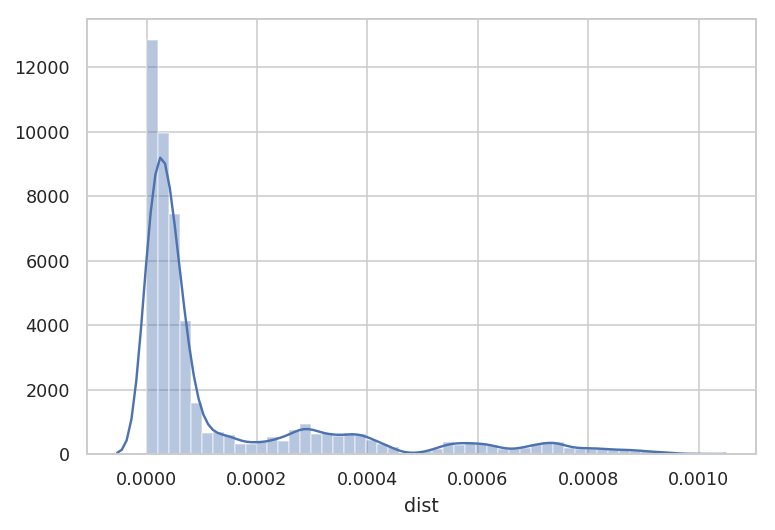

In [44]:
sns.distplot(plot_df.dist) ;

In [57]:
df = plot_df.groupby(['peak_pos', 'indiv_1'])[['dist', 'dist_af']].mean().reset_index()

dist_cutoff = 3.125e-5
dist_cutoff = 3.8e-5
#dist_cutoff = 5e-5

mean_dists = df.loc[df.dist < dist_cutoff].groupby('peak_pos').filter(lambda df: len(df) >= analysis_globals.min_sweep_clade_size).groupby('peak_pos').mean()

ust_ishim_extended_peak_regions = (mean_dists
 .reset_index()
 .merge(extended_peak_regions[['pos', 'start_pos', 'end_pos']],
       left_on=['peak_pos'], right_on=['pos'], how='left')
 .assign(length=lambda df: df.end_pos - df.start_pos)
 .drop(['pos',], axis=1)
 .assign(peak_pos=lambda df: df.peak_pos.astype(int))
 .sort_values(by='peak_pos')                                
)
ust_ishim_extended_peak_regions

,peak_pos,dist,dist_af,start_pos,end_pos,length
0,21250000,0.000029,0.000029,21100000,21600000,500000
1,36250000,0.000021,0.000021,36000000,36400000,400000
2,54350000,0.000033,0.000033,54000000,54400000,400000
3,64850000,0.000031,0.000031,64700000,65100000,400000
4,98750000,0.000022,0.000022,98500000,98900000,400000
5,110900000,0.000032,0.000032,110200000,111100000,900000
6,114150000,0.000023,0.000023,114000000,114300000,300000
7,127050000,0.000024,0.000024,126800000,127400000,600000
8,129900000,0.000031,0.000031,129700000,130200000,500000
9,131350000,0.000031,0.000031,131200000,131600000,400000


In [31]:
ust_ishim_extended_peak_regions.to_csv(results_dir / 'ust_ishim_extended_peak_regions.csv', index=False)

This way we cannot call sweeps in Ust ishim, but only see how many of the sweeps we call include Ust ishim. I.e. the sweeps that Ust Ishim is part of. We decide they are if the mean distance of all swept individusla have a mean dist to Ust ishim that is lower than 5e-5.

In [32]:
# nr_ust_ishim_shared_sweeps = (mean_dists.dist <= 5e-5).sum()
# nr_ust_ishim_shared_sweeps_af = (mean_dists.dist_af <= 5e-5).sum()

# nr_ust_ishim_shared_sweeps, nr_ust_ishim_shared_sweeps_af

In [33]:
# print("All:", (mean_dists.dist <= 5e-5).sum() / len(mean_dists))
# print("Admix filt:", (mean_dists.dist_af <= 5e-5).sum() / len(mean_dists))

How many sweeps are each non-African part of? Count how many times each individual is part of a sweep:

In [34]:
from collections import Counter
lst = list()
for tup in extended_peak_regions.itertuples():
    indivs = eval(tup.swept_indivs)    
    lst.extend(indivs)
counts = Counter(lst)    

In [35]:
df = (DataFrame.from_records(((indiv, count, individuals[indiv]['Region']) for indiv, count in counts.items()),
                 columns=['indiv', 'nr_sweeps', 'region'])
      .loc[lambda df: df.region != 'Africa']
     )

Make sure we have all non-Africans analyzed:

In [36]:
len(df), len(sweep_data.loc[lambda df: df.region_1 != 'Africa'].indiv_1.unique())

(140, 140)

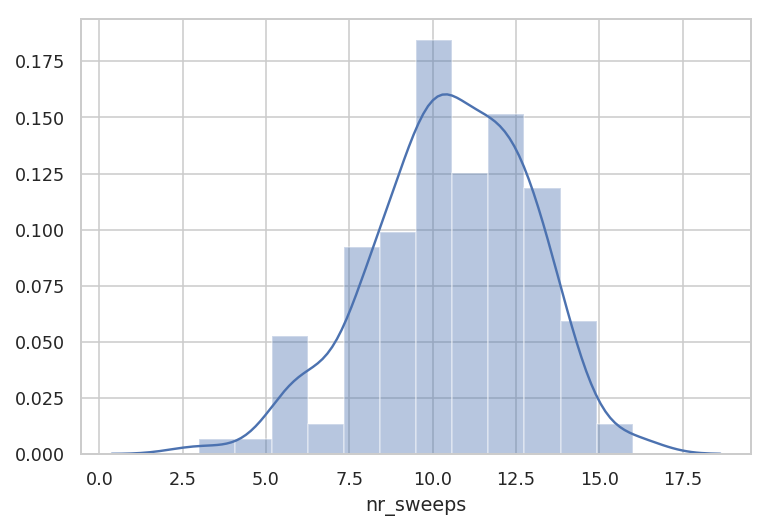

In [37]:
sns.distplot(df.nr_sweeps) ;

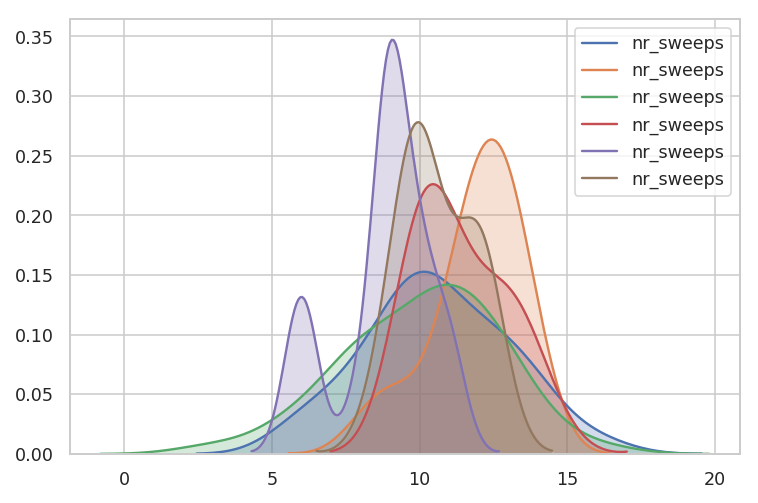

In [38]:
for region in df.region.unique():
    sns.kdeplot(df.loc[df.region==region].nr_sweeps, shade=True)

In [39]:
sns.distplotlot(df.nr_sweeps, ) ;

AttributeError: module 'seaborn' has no attribute 'distplotlot'

In [ ]:
plt.hist(df.nr_sweeps, bins=32) ;

In [ ]:
df.groupby('region').mean()

Mean and SE of mean:

In [ ]:
se = bootstrap_se(df.nr_sweeps)
print(df.nr_sweeps.mean(), df.nr_sweeps.mean()-1.96*se, df.nr_sweeps.mean()+1.96*se)

Quantiles of number of sweeps:

In [ ]:
df.nr_sweeps.quantile(0.05), df.nr_sweeps.quantile(0.95)

Total number of extended sweep regions:

In [ ]:
tot_nr_extended_sweep_regions = len(extended_peak_regions.pos.unique())
tot_nr_extended_sweep_regions